## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Тояков |
|---------|--------|
| Группа  | 407    |

Используемый датасет представляет собой множество написанных вручную цифр, от 0 до 9 включительно.

Перед загрузкой данных следует заранее добавить все используемые библиотеки:

In [29]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix, ConfusionMatrixDisplay   

# Custom libraries
from deeplearn.layers   import Layer, Softmax, CrossEntropyLoss
from deeplearn.nnetwork import NeuralNetwork

Собственно сама загрузка данных:

In [30]:
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

В переменной MNIST под ключем Train содержатся данные, разделенные на особенности и метки соответственно, но в ней нет данных для тестирования. Их можно сразу разделить:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(MNIST['Train']['Features'].astype(np.float32) / 255),
    np.array(MNIST['Train']['Labels']),
    test_size=0.3)

X_train.shape

(29400, 784)


Особенности нормализуются сразу (делением на $255$).

Создание и конфигурация нейронной сети:

In [32]:
nnet = NeuralNetwork()
nnet.configure(epoch=10, learning_rate=0.03, batch_size=5)
nnet.add_layer(Layer(784, 10))
nnet.add_layer(Softmax())

In [33]:
%time nnet.train(X_train, y_train)

CPU times: user 5.91 s, sys: 1.96 ms, total: 5.91 s
Wall time: 5.91 s


In [34]:
y_predict = nnet.predict(X_test)
y_predict

array([[2.77520097e-04, 1.43978540e-05, 2.59680366e-04, ...,
        1.14385118e-08, 1.20174065e-03, 1.28879874e-05],
       [5.81974930e-11, 9.85882621e-01, 2.84459398e-05, ...,
        2.53358520e-05, 2.78944007e-03, 9.50977355e-04],
       [1.02345146e-08, 4.49884834e-10, 1.08505669e-08, ...,
        9.60834339e-06, 4.36407019e-02, 6.98664270e-03],
       ...,
       [1.22332083e-04, 4.99147629e-03, 1.41175462e-02, ...,
        1.61740043e-03, 5.41348392e-04, 6.35232306e-05],
       [5.04494707e-08, 9.95080334e-01, 1.71427531e-03, ...,
        3.65305511e-04, 1.77704007e-03, 8.16643702e-05],
       [8.03919159e-05, 8.05449491e-06, 6.00707325e-05, ...,
        6.56345937e-01, 9.42614751e-04, 3.26970151e-01]])


Нейронная сеть возвращает матрицу вероятностей, каждая строка, в которой содержатся вероятности для каждого числа, соответствует входному образцу на этой же строке. Построчная сумма вероятностей равна единице (из определения Softmax):

In [35]:
y_predict[0].sum()

1.0

Для получения числа из каждой строки, нужно взять индекс максимума для каждой строки (индексы соответствуют меткам):

In [36]:
y_predict = np.argmax(y_predict, axis=1)

In [37]:
(y_predict == y_test).mean()

0.9157142857142857

При всех повторных запусках точность была больше $90\%$, но не исключено, что она может быть низкой из-за неудачного начального распределения весов при обучении.

Матрица ошибок имеет вид:

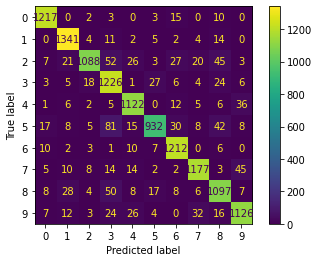

In [38]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_predict)).plot()

Интересно заметить, что большая часть ошибок появляется при определении числа 5.

Текущая конфигурация системы работает достаточно хорошо, но не достаточно быстро (~6 секунд за одну тренировку), что не есть хорошо. Скорость можно улучшить следующими способами:

    1) Уменьшить количество эпох;
    2) Увеличить коэффициент скорости тренировки;
    3) Увеличить количество обрабатываемых данных за один проход (размер батчей).\

Начинать лучше с последнего метода, так как первый метод имеет большой шанс уменьшения точности, а второй - риск, что тренировка будет перескакивать минимум. Третий метод является наилучшим (хотя бы в данном случае), так как для таких больших данных явно теряется скорость из-за обработки только пяти образцов за раз. Пусть сеть будет обрабатывать за раз 20 образцов (остальные настройки те же):

In [39]:
nnet = NeuralNetwork()
nnet.configure(epoch=10, learning_rate=0.03, batch_size=20)
nnet.add_layer(Layer(784, 10))
nnet.add_layer(Softmax())

In [40]:
%time nnet.train(X_train, y_train)

CPU times: user 2.06 s, sys: 1.75 ms, total: 2.06 s
Wall time: 2.06 s


In [41]:
y_predict = np.argmax(nnet.predict(X_test), axis=1)
(y_predict == y_test).mean()

0.9164285714285715


Точность сравнительно не изменилась, но скорость явно увеличилась в три раза.

Для графической демонстрации, тренировка нейронной сети будет выполняться одну эпоху, после чего высчитывается текущая точность. Это повторится 10 раз, что эквивалентно тренировки в промежутке 10 эпох:

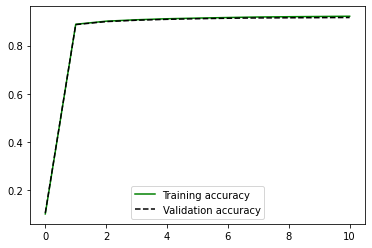

In [42]:
def get_loss_acc(net, x, y, loss=CrossEntropyLoss()):
    y_pred = net._forward_calc(x)
    l = loss.calc_forward(y_pred, y)
    pred = np.argmax(y_pred, axis=1)
    acc = (pred == y).mean()
    return l, acc

def train_plot(net, count=30):
    train_accuracies = []
    test_accuracies  = []
    
    for i in range(count + 1):
        _, train_a = get_loss_acc(nnet, X_train, y_train)
        _, test_a  = get_loss_acc(nnet, X_test, y_test)
        
        train_accuracies.append(train_a)
        test_accuracies.append(test_a)
        
        nnet.train(X_train, y_train)

    plt.plot(range(count + 1), train_accuracies, 'g-')
    plt.plot(range(count + 1), test_accuracies,  'k--')
    plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower center')
    plt.show()
    
nnet = NeuralNetwork()
nnet.configure(epoch=1, learning_rate=0.03, batch_size=20)
nnet.add_layer(Layer(784, 10))
nnet.add_layer(Softmax())
train_plot(nnet, 10)


Из графика можно сделать два вывода:

    1) Уже после первой эпохи точность близка к предельно возможной для данной конфигурации
    2) Разность между точностями на обучающих и тренировочных образцах минимальна, что означает отсутствие переобучения

Стоит еще дополнительно заметить, что процент точности можно увеличить, если увеличить количество промежуточных нейронов (но для этого нужно добавить дополнительный слой):

In [43]:
nnet = NeuralNetwork()
nnet.configure(epoch=10, learning_rate=0.03, batch_size=20)
nnet.add_layer(Layer(784, 128, activator_type='tanh'))
nnet.add_layer(Layer(128, 10))
nnet.add_layer(Softmax())

%time nnet.train(X_train, y_train)

y_predict = np.argmax(nnet.predict(X_test), axis=1)
(y_predict == y_test).mean()

CPU times: user 2min 23s, sys: 1min 36s, total: 3min 59s
Wall time: 32.7 s


0.9553174603174603

Но для этих 4-5 процент уходит много ресурсов, поэтому так следует поступать только при необходимости.